# Load data

In [2]:
#github to load signature data
import requests
import zipfile
import io
r = requests.get('https://github.com/Giles-Billenness/COM2028/raw/master/COM2028part%203(Sig%20train).zip')#change
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

r = requests.get('https://github.com/Giles-Billenness/COM2028/raw/master/COM2028part%203(Sig%20test).zip')#change
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

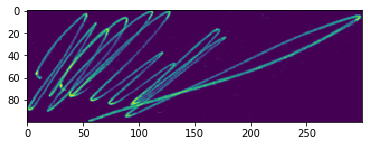

In [6]:
import cv2
#what our training/testing data looks like (after reducting the channels and resizing)
image = cv2.imread("/content/train/60/04_060.png")#load the img
#or do hog features etc.# change size
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)#convert to single channel- from 3 channel to match mnist
image = cv2.resize(image, (300, 100), interpolation = cv2.INTER_AREA)
image = cv2.bitwise_not(image)#could invert
#-----------------------------------show the image
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
plt.imshow(image, interpolation='nearest')
plt.show()
#-----------------------------------

# Fill dataset

In [7]:
import cv2
import glob
import numpy as np
import os

english_training_snippet_dir = "/content/train/"
english_testing_snippet_dir = "/content/test/"

X_train = []
y_train = []

X_test = []
y_test = []

#given the parent dir, will create append to an empty dataset array and subsiquent labels array (with each sub dir being a label)
def create_dataset_and_labels_from_parent_dir(base_dir, test_data, test_labels):
  dir_names = next(os.walk(base_dir))[1]
  print("Subdirectories are:")
  print(dir_names)

  def file_names(path):#returns a list of the file names in the directory
    return sorted([filename for filename in os.listdir(path) if filename.endswith('.png')])

  def append_img_data_and_labels(filenames, label):#given a list of file names load the img into array and appned the label of them to the labels array
    for filename in filenames:#for each filename
      image = cv2.imread(filename)#load the img
      #or do hog features etc.# change size
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)#convert to single channel- from 3 channel to match mnist
      image = cv2.resize(image, (300, 100), interpolation = cv2.INTER_AREA)
      #-----------------------------------show the image
      # from PIL import Image
      # import numpy as np
      # from matplotlib import pyplot as plt
      # plt.imshow(image, interpolation='nearest')
      # plt.show()
      #-----------------------------------
      test_data.append(image)
      test_labels.append(str(int(label)-50))
    print('Finished adding %s samples to dataset'%(str(int(label)-50)))

  for dir_name in dir_names:#for each directory in the sub dir list
    FILENAMES = file_names(base_dir + dir_name)#get file name list for that directory
    FILENAMES = [base_dir + dir_name + "/" + filename for filename in FILENAMES]#add the full path to all the filenames
    append_img_data_and_labels(FILENAMES, dir_name)#use the append method to add to dataset + labels

#-----------------------------------------------------------------------------------------------------------------------------

create_dataset_and_labels_from_parent_dir(english_training_snippet_dir, X_train, y_train)
print('X_train shape:', np.array(X_train).shape)

create_dataset_and_labels_from_parent_dir(english_testing_snippet_dir, X_test, y_test)
print('X_test shape:', np.array(X_test).shape)

Subdirectories are:
['63', '50', '54', '57', '61', '55', '59', '60', '53', '52', '58', '56', '62', '51']
Finished adding 13 samples to dataset
Finished adding 0 samples to dataset
Finished adding 4 samples to dataset
Finished adding 7 samples to dataset
Finished adding 11 samples to dataset
Finished adding 5 samples to dataset
Finished adding 9 samples to dataset
Finished adding 10 samples to dataset
Finished adding 3 samples to dataset
Finished adding 2 samples to dataset
Finished adding 8 samples to dataset
Finished adding 6 samples to dataset
Finished adding 12 samples to dataset
Finished adding 1 samples to dataset
X_train shape: (168, 100, 300)
Subdirectories are:
['63', '50', '54', '57', '61', '55', '59', '60', '53', '52', '58', '56', '62', '51']
Finished adding 13 samples to dataset
Finished adding 0 samples to dataset
Finished adding 4 samples to dataset
Finished adding 7 samples to dataset
Finished adding 11 samples to dataset
Finished adding 5 samples to dataset
Finished addi

# Neural net:

In [91]:
#invert the images
X_train = [cv2.bitwise_not(ele) for ele in X_train]
X_test = [cv2.bitwise_not(ele) for ele in X_test]

In [92]:
#convert to numpy array
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

In [93]:
%tensorflow_version 1.x
import tensorflow as tf
tf.__version__

n_inputs = 300*100
n_hidden1 = 300
n_hidden2 = 100
n_outputs = len(next(os.walk(english_training_snippet_dir))[1])#the number of classes

X_train = X_train.astype(np.float32).reshape(-1, 300*100) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 300*100) / 255.0

y_train = np.array(y_train , dtype=np.int32)#into numpy arrays
y_test = np.array(y_test,  dtype=np.int32)

#------------------------------- shuffle data and labels before split

indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)

X_train = X_train[indices]
y_train = y_train[indices]

#-------------------------------

X_valid, X_train = X_train[:6], X_train[6:]#take some validation data
y_valid, y_train = y_train[:6], y_train[6:]

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y") 

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    y_proba = tf.nn.softmax(logits)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 20
batch_size = 6

In [94]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./sig_model.ckpt")

0 Batch accuracy: 0.8333333 Validation accuracy: 0.5
1 Batch accuracy: 1.0 Validation accuracy: 0.8333333
2 Batch accuracy: 1.0 Validation accuracy: 0.8333333
3 Batch accuracy: 1.0 Validation accuracy: 1.0
4 Batch accuracy: 1.0 Validation accuracy: 1.0
5 Batch accuracy: 1.0 Validation accuracy: 1.0
6 Batch accuracy: 1.0 Validation accuracy: 1.0
7 Batch accuracy: 1.0 Validation accuracy: 1.0
8 Batch accuracy: 1.0 Validation accuracy: 1.0
9 Batch accuracy: 1.0 Validation accuracy: 1.0
10 Batch accuracy: 1.0 Validation accuracy: 1.0
11 Batch accuracy: 1.0 Validation accuracy: 1.0
12 Batch accuracy: 1.0 Validation accuracy: 1.0
13 Batch accuracy: 1.0 Validation accuracy: 1.0
14 Batch accuracy: 1.0 Validation accuracy: 1.0
15 Batch accuracy: 1.0 Validation accuracy: 1.0
16 Batch accuracy: 1.0 Validation accuracy: 1.0
17 Batch accuracy: 1.0 Validation accuracy: 1.0
18 Batch accuracy: 1.0 Validation accuracy: 1.0
19 Batch accuracy: 1.0 Validation accuracy: 1.0


In [95]:
with tf.Session() as sess:
    saver.restore(sess, "./sig_model.ckpt") # or better, use save_path
    #------------shuffle before split - to get a better look at the results
    indices = np.arange(X_test.shape[0])
    np.random.shuffle(indices)

    X_test = X_test[indices]
    y_test = y_test[indices]
    #---------------------------------
    X_new_scaled = X_test
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)
    
print("Predicted classes:", y_pred[:20])
print("Actual classes:   ", y_test[:20])

from sklearn import metrics
print("Neural net accuracy Score with test data (signature): ")
metrics.accuracy_score(y_test, y_pred, normalize=True)

INFO:tensorflow:Restoring parameters from ./sig_model.ckpt
Predicted classes: [ 2 12  0  8 11 11 11  2  1 13  5  0  9  5  9  2  9  1  3  0]
Actual classes:    [ 2 12  0  8 11 11 11  2  1 13  5  0  9  5  9  2  9  1  3  0]
Neural net accuracy Score with test data (signature): 


1.0

INFO:tensorflow:Restoring parameters from ./sig_model.ckpt
[[12  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 12  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 12  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 12  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 12  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 12  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 12  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 12  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 12  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 12]]


Text(0.5, 51.0, 'Predicted label')

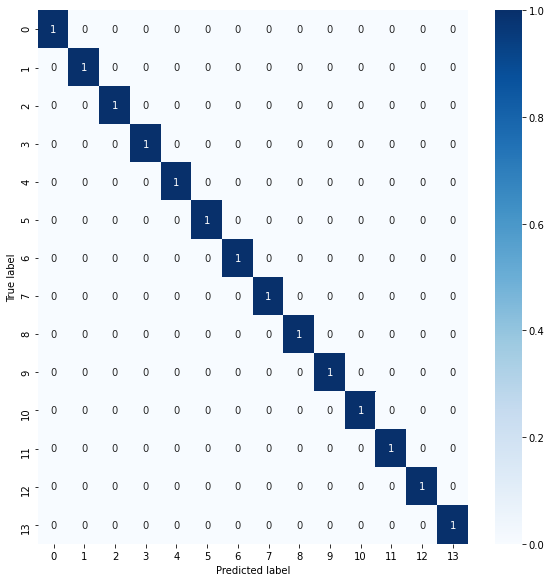

In [96]:
import sys
import numpy
#for the numpy array output version
numpy.set_printoptions(threshold=sys.maxsize)#to display all rows
numpy.set_printoptions(linewidth =sys.maxsize)#makes it so it the rows dont wrap around

with tf.Session() as sess:
    saver.restore(sess, "./sig_model.ckpt")
    confusion = tf.confusion_matrix(labels=y_test, predictions=y_pred, num_classes=len(next(os.walk(english_training_snippet_dir))[1]))#for its own data (split from the training dataset)
    numpy_con_mat = confusion.eval(session=sess)
    print(numpy_con_mat)
    

con_mat_norm = np.around(numpy_con_mat.astype('float') / numpy_con_mat.sum(axis=1)[:, np.newaxis], decimals=2)#get relative frequency for prediction labels

import pandas as pd

labels_correct =[0,1,2,3,4,5,6,7,8,9,10,11,12,13]
con_mat_df = pd.DataFrame(con_mat_norm)

from matplotlib import pyplot as plt
import seaborn as sns

figure = plt.figure(figsize=(8, 8))

sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


# SVM & KNN hog features:

In [8]:
from skimage.feature import peak_local_max, hog
#get hog features for each
X_train = [hog(ele, orientations=12, pixels_per_cell=(4, 4), cells_per_block=(2, 2)) for ele in X_train]#larger pixels per cell due to larger image
#y_train

X_test = [hog(ele, orientations=12, pixels_per_cell=(4, 4), cells_per_block=(2, 2)) for ele in X_test]
#y_test

In [9]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
print('Training the SVM')
svm_clf = LinearSVC(dual=False,verbose=1)#create the SVC (linear)
svm_clf.fit(X_train, y_train)#train the svm with the data provided.

scores = cross_val_score(svm_clf, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Training the SVM
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Accuracy: 0.96 (+/- 0.09)


In [10]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
print('Training the KNN')
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=2)
knn_clf.fit(X_train, y_train)

scores = cross_val_score(knn_clf, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Training the KNN
Accuracy: 0.83 (+/- 0.16)


In [11]:
test_predict_svm =[]#predicted labels for the test data
test_predict_knn =[]

#test each prediction method to gen predicted labels for the test data
for ele in X_test:
  result_type_svm = svm_clf.predict(ele.reshape(1,-1))
  test_predict_svm.append(result_type_svm)#add svm predictions

  result_type_KNN = knn_clf.predict(ele.reshape(1,-1))
  test_predict_knn.append(result_type_KNN)#add knn predictions

In [12]:
from sklearn import metrics
print("SVM accuracy Score with test data: ")
metrics.accuracy_score(y_test, test_predict_svm, normalize=True)

SVM accuracy Score with test data: 


1.0

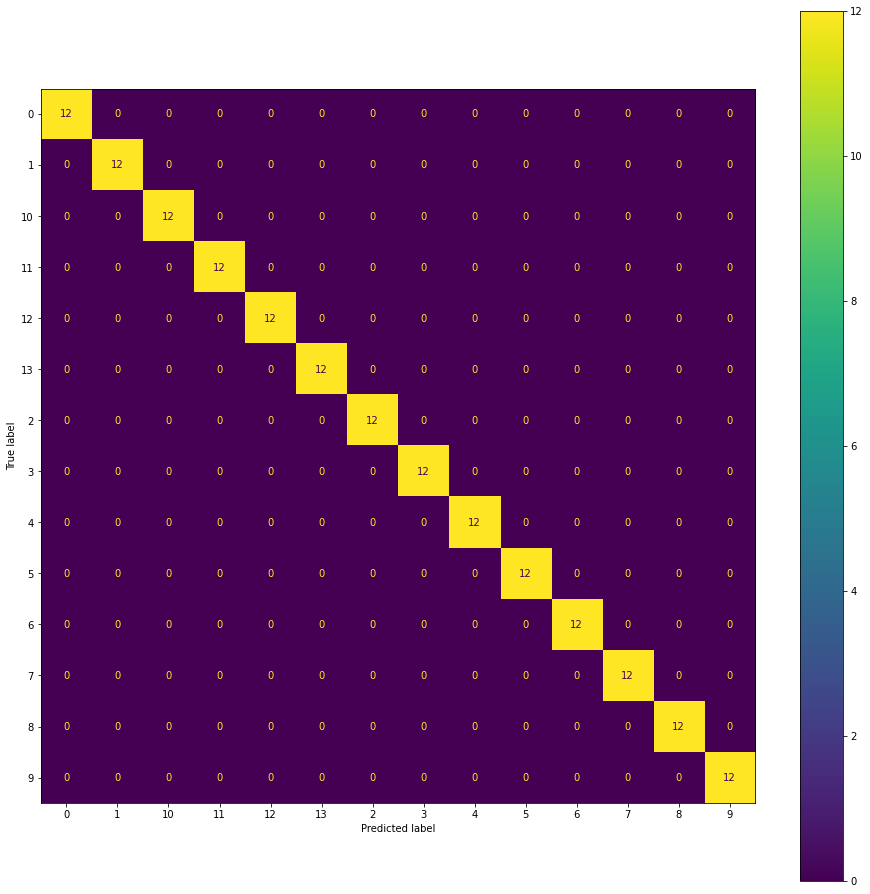

In [13]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 16))
plot_confusion_matrix(svm_clf, X_test, y_test, ax=ax)

In [14]:
print("KNN accuracy Score with test data: ")
metrics.accuracy_score(y_test, test_predict_knn, normalize=True)

KNN accuracy Score with test data: 


1.0

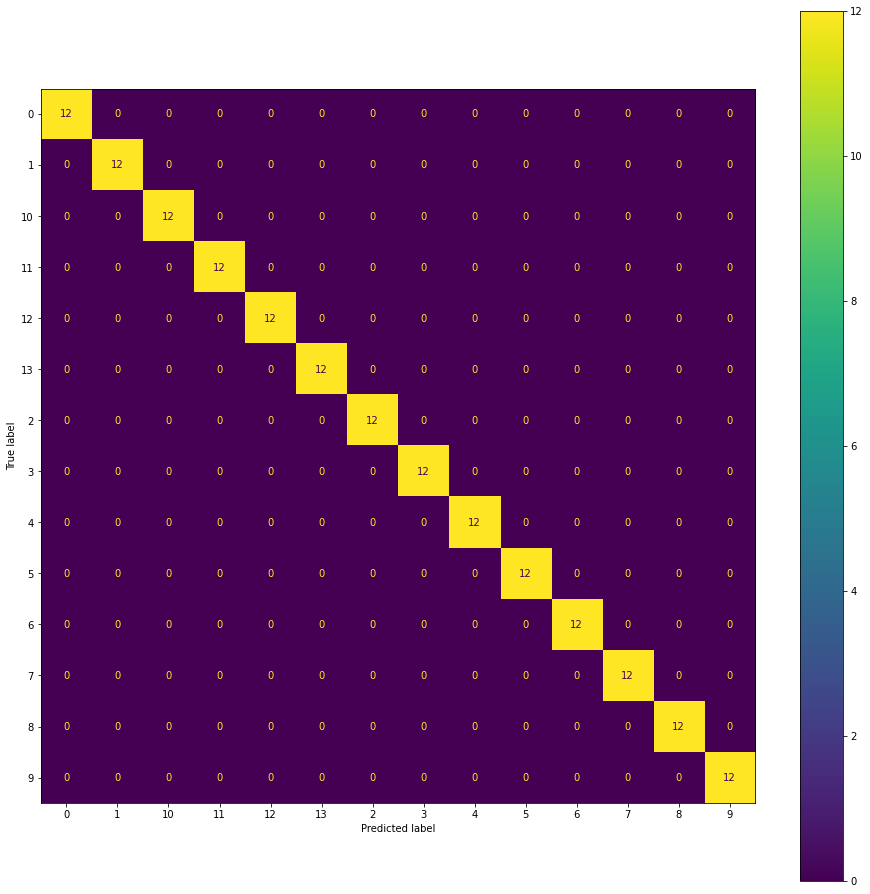

In [15]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 16))
plot_confusion_matrix(knn_clf, X_test, y_test, ax=ax)